In [74]:
import torch
from datetime import datetime
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']


torch.manual_seed(42) # To ensure sanity
print(device)

cpu


In [80]:
class CutDataset(Dataset):
    """Field Cut dataset"""

    def __init__(self, file_arr, data_dir, param_dir):
        """
        Args:
            file_arr (integer array): Array of file numbers.
            root_dir (Path Object): Directory with all the data.
            param_dir (Path Object): Directory with parameter data.
        """
        
        self.field_cut = []
        for file in file_arr:
            
            file_to_open = data_dir / (str(file) + '.cut')
            V_INI, V_INC, V_NUM, C, ICOMP, ICUT, NCOMP = np.genfromtxt(file_to_open, max_rows=1, skip_header=1)
            thetas = torch.linspace(V_INI,V_INI+V_INC*(V_NUM-1),int(V_NUM))
            self.field_cut = np.append(self.field_cut, np.genfromtxt(file_to_open, skip_header=2,dtype = np.float32).T)
        
        
        self.field_cut = torch.from_numpy(self.field_cut)
        
        #Ensure that only chosen field-cut paramters are chosen
        self.parameters = torch.from_numpy(np.genfromtxt(param_dir, skip_header=2,dtype = np.float32).T)
        self.parameters = self.parameters[file_arr]
        
        

    def __len__(self):
        return len(self.field_cut.shape[2])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        parameters = self.parameters[idx]
        field_cut = self.field_cut[idx]
        
        sample = {'parameters': parameters, 'field_cut': field_cut}

        return parameters, field_cut
    
    


## Define Data Path

In [4]:
cwd = Path.cwd()
cut_folder = Path(r'C:\Users\Niels\Documents\GitHub\Supervised-Machine-Learning-for-Space-Antenna-Performance-Prediction\Prelimary Data Analysis\Field Cut Data\cut_files')
cut_file_list = cut_folder.glob('*00.cut')
log_file = Path(r'C:\Users\Niels\Documents\GitHub\Supervised-Machine-Learning-for-Space-Antenna-Performance-Prediction\Prelimary Data Analysis\Field Cut Data\log_files\lookup.log')

In [69]:
indexArray = [int(x) for x in range(0,2499)]
cutData = CutDataset(indexArray,cut_folder,log_file)

In [76]:
train_dataloader = DataLoader(cutData, batch_size=64, shuffle=True)

AttributeError: 'CutDataset' object has no attribute 'landmarks_frame'

## Load Data

In [8]:
file_to_open = cut_folder / '0.cut'
data = np.genfromtxt(file_to_open, skip_header=2,dtype = np.float32).T.reshape(4,1001,1)

for i in range(1,2499):
    file_to_open = cut_folder / (str(i)+'.cut')
    openFileData = np.genfromtxt(file_to_open, skip_header=2,dtype = np.float32).T.reshape(4,1001,1)
    data = np.append(data,openFileData,axis = 2)

In [79]:
parameters = np.genfromtxt(log_file, skip_header=2,dtype = np.float32).T
parameters = parameters[1:]
print(data.shape)
print(parameters.shape[1])

(4, 1001, 2499)
2499


## Normalize Data

In [49]:
parameters_std = np.std(parameters,axis=1).reshape(3,1)
parameters_mean = np.mean(parameters,axis = 1).reshape(3,1)

parameters_norm = (parameters-parameters_mean)/parameters_std
print('Standard Deviation Test',np.std(parameters_norm,axis=1))
print('Standard Deviation Test',np.mean(parameters_norm,axis=1))

data_std = np.std(data,axis=0)


print(data_std)
print(data_std.shape)

Standard Deviation Test [0.99999833 0.9999948  0.99999946]
Standard Deviation Test [ 5.5281816e-06  1.4778327e-07 -1.7415337e-05]
[[0.04585529 0.05411821 0.04455388 ... 0.01072068 0.00759017 0.01723341]
 [0.04735412 0.05537884 0.04510447 ... 0.012502   0.01451338 0.01044451]
 [0.04888898 0.05659285 0.04568626 ... 0.00806006 0.00765275 0.01213   ]
 ...
 [0.05072174 0.05699085 0.04600365 ... 0.07528765 0.05142327 0.0333252 ]
 [0.04920594 0.05579222 0.04544083 ... 0.03896202 0.04487289 0.02556615]
 [0.0477219  0.0545473  0.04490957 ... 0.0027425  0.03545754 0.01714657]]
(1001, 2499)


### And check normalization 

Standard Deviation Test [0.99999833 0.9999948  0.99999946]
Standard Deviation Test [ 5.5281816e-06  1.4778327e-07 -1.7415337e-05]


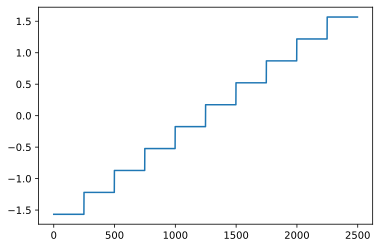

In [84]:

print('Standard Deviation Test',np.std(parameters_norm,axis=1))
print('Standard Deviation Test',np.mean(parameters_norm,axis=1))




plt.figure()
plt.plot(parameters_norm[2,:])

## Make NN Model

In [123]:


NN = 10;
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.regressor = nn.Sequential(nn.Linear(3, NN),
                                       nn.Tanh(),
                                       nn.Linear(NN, NN),
                                       nn.Tanh(),
                                       nn.Linear(NN, 4))
        
    def forward(self, x):
        output = self.regressor(x)
        return output

    
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)
                                       
                                       
                                       
                                       
net = Net()
print(net(torch.from_numpy(parameters_norm[:,1])))

print(parameters_norm[:,0:200].shape)




tensor([-0.3333,  0.2521, -0.1457, -0.2949], grad_fn=<AddBackward0>)
(3, 200)


In [98]:
m = nn.BatchNorm1d(3, affine=False)
input = torch.randn(2, 3)
output = m(input)
print(input)
print(output)

tensor([[ 0.4980,  0.2412, -0.6363],
        [-0.6896, -2.1172, -1.7568]])
tensor([[ 1.0000,  1.0000,  1.0000],
        [-1.0000, -1.0000, -1.0000]])
